# Searching for Indian Restaurants in NYC

## 1. Introduction

### 1.1 Abstract

New york is the most populous city in United States. NYC is dense, diversified city with eight and half million population coming from different cultures and societies. It has been described as the cultural, financial, and media capital of the world. Due of its business friendly environment, it provides lot of business opporutinites. It has been significantly influencing lot of immigirants to move to this city. Since lot of people from all around the world move there, this city serves differenet kind of cuisines. There are many cusinies on the basis of cooking style, ingredients, dishes and techniques. While visiting to new city, travellers might find it difficult to search best cuisine of their choice. In this project, I will be catering to the problem of finding Indian restaurants in NYC. Project will also help to find best Indian cuisine near them and sort them according to ratings and likes. 

### 1.2 Business Problem

In this project , we will try to find answers of following questions for Indian Restauarnts:
- if someone wants to open new restaurants in the city, which is the best location?
- who are the competitors and what are their rating?
- which area provides max no. of Indian cuisine ?
- which restaurant is mostly liked or highly recommened?
- where can one find the best Indian food in the nearby area?

For this we will determine focus upon market places, competitors, population, food preferences, locality .  We will also focus upon number of restauarants present per Neighborhood as well as per Borough. This will help to understand the locality and competition already . This will also help travellers an easy apporach to find their cuisine according to the location.

## 2. Data Description

### 2.1 Data

For this project, data required for analysis includes information about neighborhoods, boroughs which contains latitude, longitude, restuarant details about ratings and tips. Data sources included for project include:
 - NYC data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset
 - Data related to restarauant details (location, ratings, likes) will be collected from the data source: Foursqaure

### 2.2 How Data will be used to solve problem?

Firstly, data will be collected to determine information abour all restauarants presnet in NYC. This includs information about location of all restauarants in 5 Borough and 306 neighborhoods of new york city. After this, data will be cleaned to give list of only Indian restauarants present in each Borough and Neighorhoods. The venues will be filtered according to their ratings and preferences. Data visualization using Folium Maps will give clear idea about the top restaurants present in the nearby area.

## 3. Methodology

Our main goal is to get deatils of Indian Resturants in NYC for all neighorhoods and Boroughs. For this, we will follow following approach:
 - Data will be extracted from https://cocl.us/new_york_dataset, cleaned and processed into a dataframe.
 - Restuatant details will be obtained from Foursquare and filtered by Indian Restuarants. We will count tips, ratings and liked od restuarants.
 - Sort the data on the basis of ratings and locations.
 - Data will be visually represented using Folium Maps
 

### Exploratory Data Analysis

Lets begin the coding

In [3]:
# import libraraies
import pandas as pd
import numpy as np
import requests

import folium

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

In [17]:
CLIENT_ID = '4G4K201OP1ZVO02JR23HKPVZU5IBMC1Q5DJQ1UQNXMD2NHZC' # Foursquare ID
CLIENT_SECRET ='NNIPOPIUGTS2QN4M10NNIGDPGSP3U1C0ODHK2UCB5LRRBGFZ' # Foursquare Secret
VERSION = '20180604'

In [7]:
# Define function to extract NYC data
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
ny_data = get_new_york_data()

In [9]:
ny_data.tail()

,Borough,Neighborhood,Latitude,Longitude
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631
305,Staten Island,Fox Hills,40.617311,-74.081740


In [10]:
ny_data.shape

(306, 4)

#### Analysing restaurants in the neighborhood

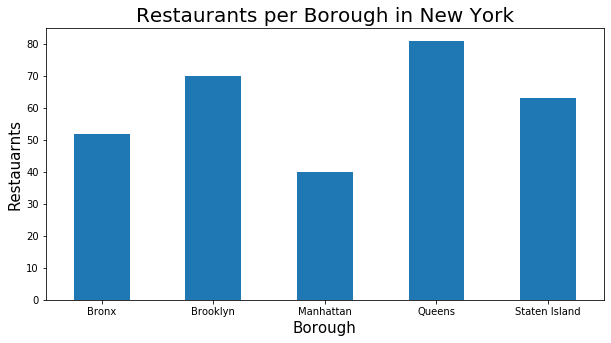

In [11]:
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5))
plt.title('Restaurants per Borough in New York', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Restauarnts',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In the above graph, we can see that maximum number of restauants per Borough are in the Queens, followed by those in Brooklyn. 

In [13]:
#defining functions to determine location
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [14]:
def get_venues(lat,lng):
    
    radius=1000
    LIMIT=100
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
        
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Lets prepare neighorhood list of Indian Restuarants in NYC

In [18]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)

print('List of Indian restaurants in NYC \n---------------------')
       
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']
    if len(indian_resturants) > 0:
        print(Neighborhood+', '+Borough+' : '+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)

List of Indian restaurants in NYC 
---------------------
Woodlawn, Bronx : 1
Parkchester, Bronx : 2
Spuyten Duyvil, Bronx : 1
Concourse, Bronx : 1
Unionport, Bronx : 1
Bay Ridge, Brooklyn : 2
Brighton Beach, Brooklyn : 1
Flatbush, Brooklyn : 2
East Flatbush, Brooklyn : 1
Kensington, Brooklyn : 2
Prospect Heights, Brooklyn : 1
Fort Greene, Brooklyn : 1
Clinton Hill, Brooklyn : 1
Downtown, Brooklyn : 1
Prospect Lefferts Gardens, Brooklyn : 1
Ocean Hill, Brooklyn : 2
Prospect Park South, Brooklyn : 2
South Side, Brooklyn : 1
Fort Hamilton, Brooklyn : 1
Washington Heights, Manhattan : 1
Hamilton Heights, Manhattan : 2
Manhattanville, Manhattan : 2
Central Harlem, Manhattan : 2
East Harlem, Manhattan : 1
Yorkville, Manhattan : 2
Roosevelt Island, Manhattan : 1
Upper West Side, Manhattan : 1
Midtown, Manhattan : 2
Tribeca, Manhattan : 1
West Village, Manhattan : 1
Manhattan Valley, Manhattan : 3
Morningside Heights, Manhattan : 1
Gramercy, Manhattan : 6
Astoria, Queens : 1
Woodside, Queens :

Analysing how many Indian restaurants are there in the neighbourhood

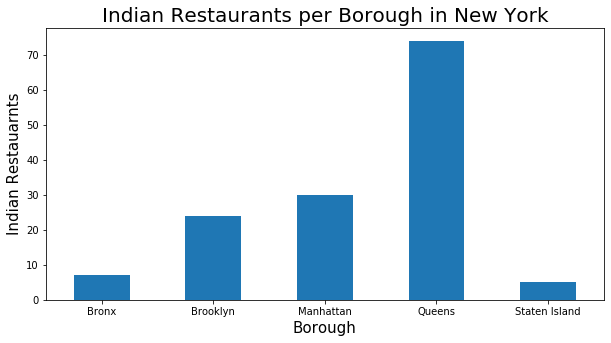

In [19]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5))
plt.title('Indian Restaurants per Borough in New York', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Indian Restauarnts',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

As per the observations from the graph, it can be found that Queens has highest number of Indian Restuarants

Lets analyse Top 10 neighborhoods based on the number of Indian cuisine restaurants in New York city.

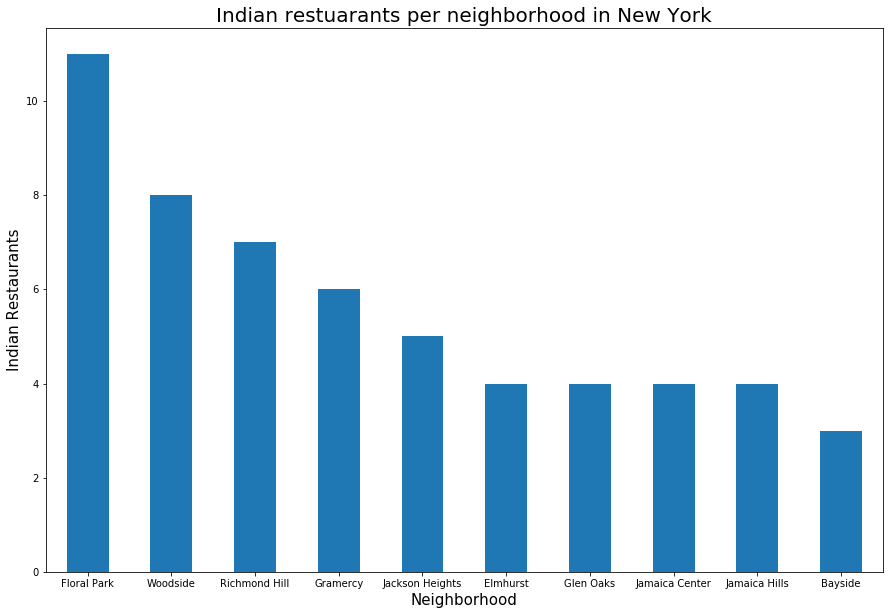

In [22]:
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot.bar(figsize=(15,10)) #top 10 restauarants 
plt.title('Indian restuarants per neighborhood in New York', fontsize = 20)
plt.xlabel('Neighborhood',fontsize = 15)
plt.ylabel('Indian Restaurants',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [23]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
101,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
102,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
103,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
104,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
105,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
106,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
107,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
108,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
109,Queens,Floral Park,51d84192498ea979a3c4f13d,Sunshine Grill & Restaurant
110,Queens,Floral Park,4c3e17f2ca012d7f82022fbe,Mushin's Halal Food [Gyro Cart]


In [24]:
# preparing neighborhood list of indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.8    10
( 1 / 140 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 2 / 140 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 3 / 140 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.0     9
( 4 / 140 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.8     3
( 5 / 140 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 6 / 140 ) processed
                         ID       Name  Likes  Rat

KeyError: 'venue'

Data Cleaning for data integrity

In [25]:
convert_types = { 'Likes': float, 'Tips': float }
indian_rest_stats_ny = indian_rest_stats_ny.astype(convert_types)
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [26]:
#Restauranats with most tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a12eb1ff964a52099771fe3
Name                               Dhaba
Likes                                497
Rating                               8.3
Tips                                 164
Name: 47, dtype: object

In [27]:
#Restauarants with max likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               8.6
Tips                                 148
Name: 39, dtype: object

In [28]:
#Restauarants with max ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              57596dad498e732300496b23
Name                         Dosa Royale
Likes                                 76
Rating                               8.8
Tips                                  22
Name: 15, dtype: object

### Create list of top 10 neighborhood in order of their average rating of restaurants

In [66]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [67]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
9,Fort Greene,8.80
3,Clinton Hill,8.80
20,Prospect Heights,8.70
21,Prospect Lefferts Gardens,8.70
30,West Village,8.70
26,Tribeca,8.60
23,Roosevelt Island,8.50
28,Upper West Side,8.50
24,South Side,8.40
11,Gramercy,8.38


### Average rating of Indian Resturants for each Borough

In [38]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [58]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.076000
1,Brooklyn,7.863158
0,Bronx,5.433333


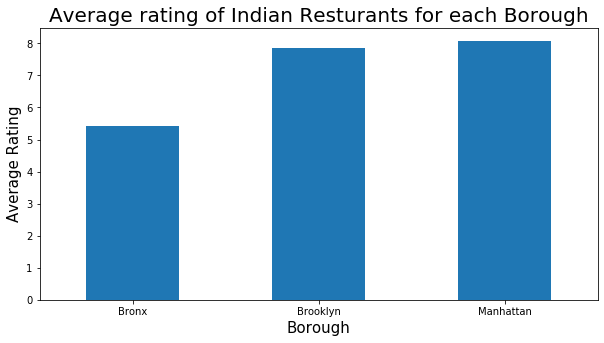

In [59]:
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5))
plt.title('Average rating of Indian Resturants for each Borough', fontsize=20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

### List of neighborhoods with average rating of >=7 for Indian cuisine

In [68]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [69]:
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Central Harlem,8.00
3,Clinton Hill,8.80
5,Downtown,8.00
6,East Flatbush,8.30
9,Fort Greene,8.80
11,Gramercy,8.38
18,Ocean Hill,8.00
20,Prospect Heights,8.70
21,Prospect Lefferts Gardens,8.70
23,Roosevelt Island,8.50


In [71]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')

In [72]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

### Mapping the restaurants for better visualtisation using folium map

In [73]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [74]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='#EA1253',
            fill=True,
            fill_color='#12EA92',
            fill_opacity=0.4
        )
    )

In [75]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [76]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## 4. Results and Discussions

From the above analysis, we have observe following:
 - Maximum number of restauants per Borough are in the Queens, followed by those in Brooklyn.
 - There are highest number of Indian restuarants in the neighorhood of Floral Park.
 - Queens has maximum number of Indian restuarnts among all Boroughs.
 - Indian restuarant with highest tips and likes are in Manhattan.
 - Staten Island ranks last in average rating of Indian Resturants.
 - Map clearly shows all the Indian restuarants located in NYC.
 
Manhattan has the highest potential of Indian cuisine market. There is scope of improving ratings of Indian Restauarnts in Bronx and Staten Island. 

## 5. Conclusion

We can easily fing that NYC has several number of Indian restauarant present in each corner of the neighourhood. Queen and Brooklyn have highest number of Indian cuisine serving places. But as far as ratings are concerned, Manhattan has higher potential for Indian cuisine. Staten Island ranks last in average rating of Indian Resturants.
Since the analysis is performed on limited data, there might be deligency in the accuracy.But if larger set of data can be analysed, there will be better scope of improvement .